In [309]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import srsly
from datasets import load_from_disk
from matplotlib import ticker
from scipy.special import entr, softmax
from sklearn.manifold import TSNE
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from tqdm.auto import tqdm

In [20]:
path_to_experiment = Path("../outputs/multirun/reinit_effect/patch")
path_to_experiment

PosixPath('../outputs/multirun/reinit_effect/patch')

---
### Pool uncertainty

In [22]:
dataset = "agnews"
strategy = "entropy"

In [23]:
original_df = load_from_disk(f"../data/processed/{dataset}/")["train"].to_pandas()

/home/pl487/.conda/envs/anchoral/lib/python3.9/site-packages/datasets/dataset_dict.py:1241: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [24]:
paths = list((path_to_experiment / dataset).iterdir())
paths

[PosixPath('../outputs/multirun/reinit_effect/patch/agnews/margin_confidence'),
 PosixPath('../outputs/multirun/reinit_effect/patch/agnews/entropy'),
 PosixPath('../outputs/multirun/reinit_effect/patch/agnews/random')]

In [26]:
data = []
stage = "pool"

list_df = []
for dataset in tqdm(list(path_to_experiment.iterdir())):
    if dataset.name == "imdb":
        continue
    original_df = load_from_disk(f"../data/processed/{dataset.name}/")[
        "train"
    ].to_pandas()
    for strategy in tqdm(list(dataset.iterdir())):
        if strategy.name == "random":
            continue
        for reinit in tqdm(list(strategy.iterdir())):
            for run in tqdm(list(reinit.iterdir())):
                data_seed, model_seed = run.name.split("_")

                df = pd.concat(
                    [
                        pd.read_csv(i).assign(stage=stage)
                        for i in (run / "logs" / stage).glob("*csv")
                    ]
                )

                # add labels
                df = pd.merge(
                    df,
                    original_df[["unique_id", "labels"]],
                    on="unique_id",
                    how="left",
                )

                # add logits and margin
                logits = df.iloc[:, df.columns.str.startswith("logit")].values
                probs = softmax(logits, axis=1)
                sorted_probs = np.take_along_axis(probs, probs.argsort(-1), axis=1)
                df = df.assign(
                    entropy=entr(probs).sum(-1),
                    margin=sorted_probs[:, -1] - sorted_probs[:, -2],
                    preds=probs.argmax(-1),
                    prob_pred=probs.max(-1),
                    prob_true=lambda df_: np.take_along_axis(
                        probs, df_["labels"].values.reshape(-1, 1), axis=1
                    ),
                )

                # aggregate
                df_agg = (
                    df.groupby("round")[
                        ["entropy", "margin", "prob_pred", "prob_true"]
                    ]
                    .agg(["mean", "max", "min", "std", "size"])
                    .assign(
                        data_seed=int(data_seed.split("=")[1]),
                        model_seed=int(model_seed.split("=")[1]),
                        dataset=dataset.name,
                        strategy=strategy.name,
                        reinit=eval(str(reinit.name).split("=")[-1]),
                    )
                )

                list_df.append(df_agg)

  0%|          | 0/2 [00:00<?, ?it/s]

/home/pl487/.conda/envs/anchoral/lib/python3.9/site-packages/datasets/dataset_dict.py:1241: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [29]:
agnews = pd.concat(list_df).reset_index()
agnews

round   entropy                                          margin  \
                mean       max       min       std    size      mean   
0        0  1.345156  1.386288  1.246575  0.020837  119900  0.093261   
1        1  1.238897  1.386105  1.071700  0.068917  119875  0.197176   
2        2  0.660242  1.381409  0.401766  0.218096  119850  0.660181   
3        3  1.313764  1.386287  1.206977  0.032512  119825  0.126493   
4        4  1.071028  1.385984  0.880400  0.103002  119800  0.371453   
...    ...       ...       ...       ...       ...     ...       ...   
1595    95  0.043686  1.369069  0.002529  0.140392  117525  0.970846   
1596    96  0.044478  1.375025  0.002372  0.141967  117500  0.970015   
1597    97  0.041132  1.373965  0.002305  0.137721  117475  0.972166   
1598    98  0.043669  1.359883  0.002020  0.143786  117450  0.970795   
1599    99  0.036511  1.343246  0.001766  0.130056  117425  0.974753   

                                        ... prob_true                      \
           max           min       std  ...      mean       max       min   
0     0.310907  1.126797e-08  0.060837  ...  0.336130  0.494945  0.135719   
1     0.457235  3.427092e-06  0.114664  ...  0.419189  0.616606  0.075252   
2     0.866518  2.649361e-05  0.231106  ...  0.691702  0.908388  0.015312   
3     0.338320  6.139791e-06  0.075013  ...  0.370904  0.521894  0.117026   
4     0.605891  3.721954e-06  0.163758  ...  0.536823  0.723840  0.044256   
...        ...           ...       ...  ...       ...       ...       ...   
1595  0.999667  2.985034e-04  0.122107  ...  0.864811  0.999757  0.000048   
1596  0.999691  2.270916e-04  0.124355  ...  0.864510  0.999774  0.000047   
1597  0.999696  5.125916e-05  0.119731  ...  0.867250  0.999780  0.000045   
1598  0.999742  7.661923e-05  0.122713  ...  0.866897  0.999811  0.000037   
1599  0.999778  5.447691e-04  0.114793  ...  0.868769  0.999837  0.000033   

                       data_seed model_seed dataset           strategy reinit  
           std    size                                                         
0     0.060180  119900         0          0  agnews  margin_confidence   True  
1     0.116389  119875         0          0  agnews  margin_confidence   True  
2     0.275181  119850         0          0  agnews  margin_confidence   True  
3     0.071256  119825         0          0  agnews  margin_confidence   True  
4     0.167294  119800         0          0  agnews  margin_confidence   True  
...        ...     ...       ...        ...     ...                ...    ...  
1595  0.326680  117525      1994       1994  agnews            entropy  False  
1596  0.326573  117500      1994       1994  agnews            entropy  False  
1597  0.324676  117475      1994       1994  agnews            entropy  False  
1598  0.324366  117450      1994       1994  agnews            entropy  False  
1599  0.324444  117425      1994       1994  agnews            entropy  False  

[1600 rows x 26 columns]

In [97]:
plot_data = (
    agnews.set_index(["round", "strategy", "reinit"])
    .drop(columns=["data_seed", "model_seed", "dataset"])
    .stack(0)
    .reset_index()
    .rename(columns={"level_3": "metric", "reinit": "re-initialise"})
    .rename(columns={})
    .sort_values("strategy")
)

In [98]:
plot_data

,round,strategy,re-initialise,metric,max,mean,min,size,std
6399,99,entropy,False,prob_true,0.999837,0.868769,0.000033,117425,0.324444
4271,67,entropy,True,prob_true,0.680435,0.505251,0.059708,118225,0.129114
4270,67,entropy,True,prob_pred,0.680435,0.537497,0.252994,118225,0.082103
4269,67,entropy,True,margin,0.564907,0.316707,0.000019,118225,0.141991
4268,67,entropy,True,entropy,1.386238,1.152378,0.971853,118225,0.079732
...,...,...,...,...,...,...,...,...,...
2128,32,margin_confidence,False,entropy,1.349504,0.081092,0.007301,119100,0.183397
2127,31,margin_confidence,False,prob_true,0.999151,0.856376,0.000136,119125,0.315230
2126,31,margin_confidence,False,prob_pred,0.999151,0.962689,0.309537,119125,0.097418
2124,31,margin_confidence,False,entropy,1.352036,0.109447,0.007752,119125,0.213362


In [99]:
sns.diverging_palette(250, 30, l=65, center="dark", n=3)

[(0.4265534711840377, 0.6260975213663689, 0.9072715683943962),
 (0.14918455888545099, 0.1381228160190642, 0.13476544093324597),
 (0.90499399934908, 0.5182704637470051, 0.3064196349089693)]

In [100]:
def plot(plot_data, dpi, ymin, title, metric, y):
    colors = sns.diverging_palette(250, 30, l=65, center="dark", n=3)

    plt.style.use("bmh")
    sns.set_context("paper")

    # plot
    fig, ax = plt.subplots()
    fig.dpi = dpi

    sns.lineplot(
        data=plot_data.loc[(plot_data["metric"] == metric)],
        x="round",
        y=y,
        hue="strategy",
        style="re-initialise",
        ax=ax,
        palette=colors,
    )

    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
    # ax.set_xlim(0, 100)
    ax.set_ylim(ymin)

    fig.suptitle(title)
    ax.set_title(
        f"average {y} {metric} on the entire pool across rounds", fontsize=10
    )
    ax.set_ylabel(metric)
    ax.set_xlabel("Labelling round")
    ax.legend(fontsize=10, bbox_to_anchor=(1, 1))

    sns.despine()
    plt.show()

/tmp/ipykernel_2520241/3708231446.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.lineplot(data=plot_data.loc[(plot_data["metric"] == metric)], x="round", y=y, hue="strategy", style="re-initialise", ax=ax, palette=colors)


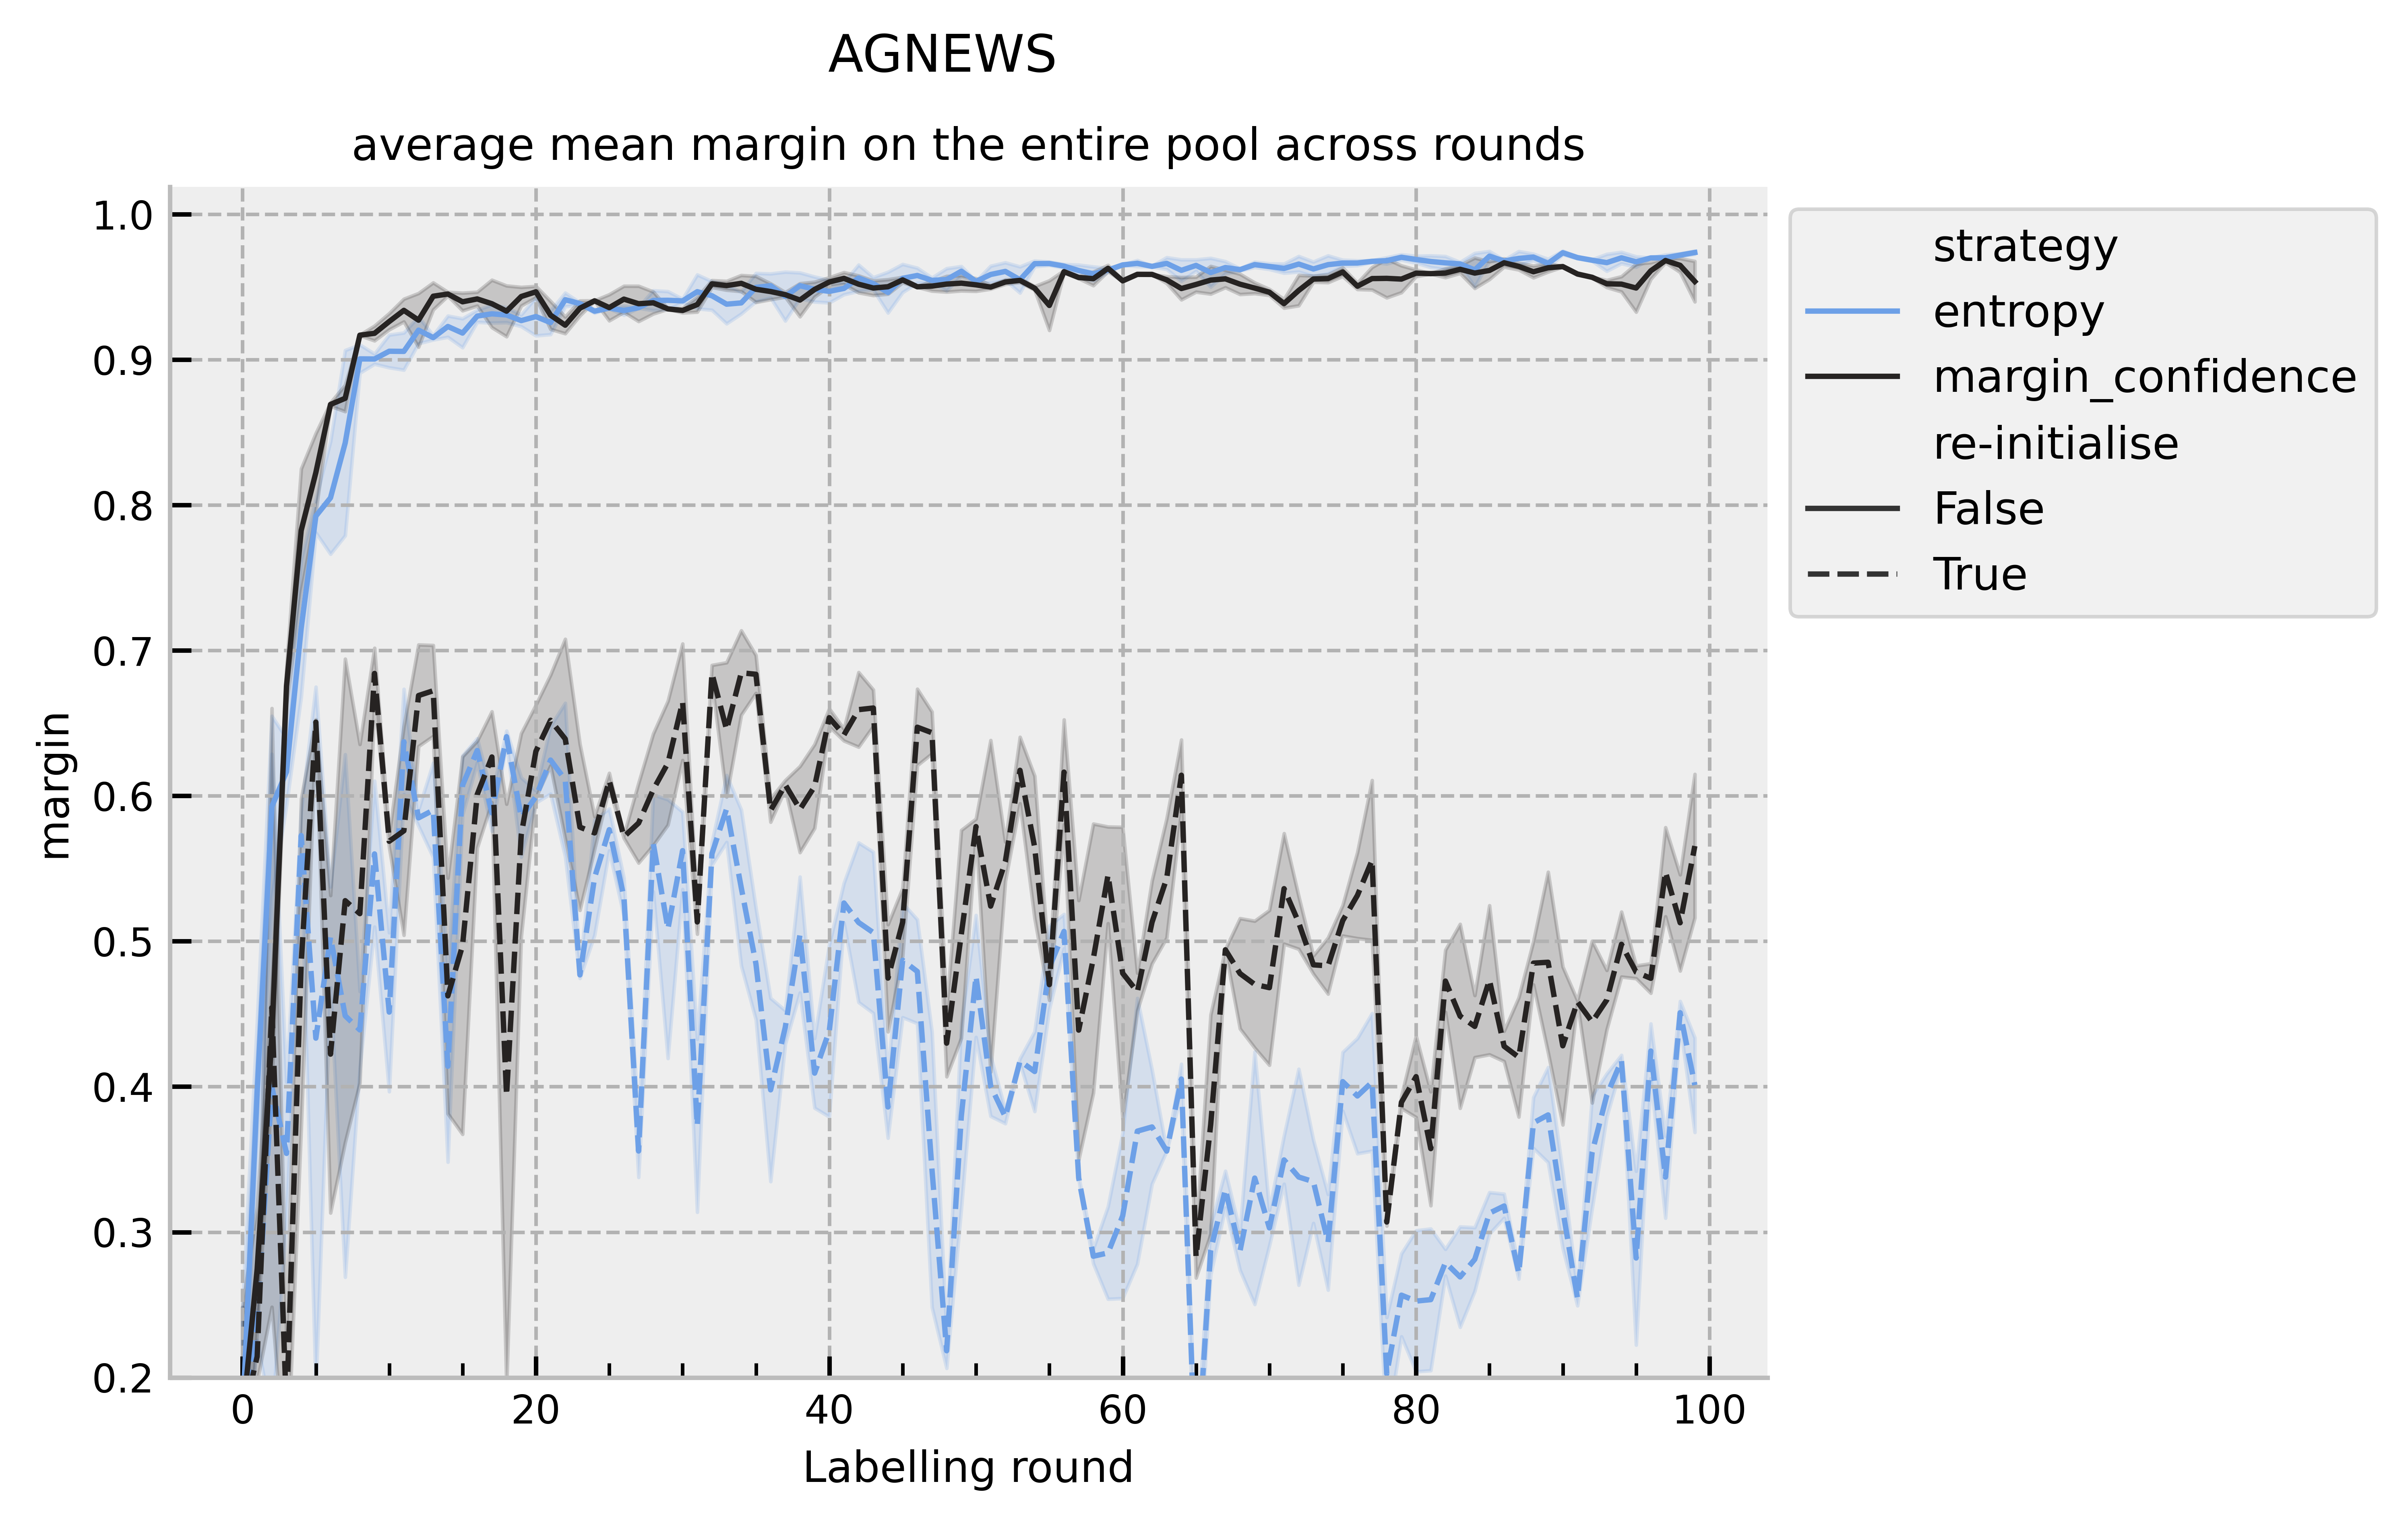

In [107]:
plot(plot_data, dpi=800, ymin=0.2, title="AGNEWS", metric="margin", y="mean")

---
### Similarity between selected subsets

In [108]:
path_to_experiment

PosixPath('../outputs/multirun/reinit_effect/patch')

In [127]:
list_dfs = []
for strategy in (path_to_experiment / "agnews").iterdir():
    for reinit in strategy.iterdir():
        for run in reinit.iterdir():
            data_seed, model_seed = run.name.split("_")
            df = pd.read_parquet(run / "logs" / "labelled_dataset.parquet").assign(
                reinit=eval(reinit.name.split("=")[1]),
                strategy=strategy.name,
                experiment=run.name,
                data_seed=int(data_seed.split("=")[1]),
                model_seed=int(model_seed.split("=")[1]),
            )
            list_dfs.append(df)

In [137]:
df = pd.concat(list_dfs).reset_index(drop=True)

In [259]:
def jaccard_similarity(A, B):
    # Find intersection of two sets
    nominator = A.intersection(B)

    # Find union of two sets
    denominator = A.union(B)

    # Take the ratio of sizes
    similarity = len(nominator) / len(denominator)

    return similarity


def compute_jaccard(df, a, b):
    A = set(df.loc[df["strategy"] == a, "unique_id"].unique())
    B = set(df.loc[df["strategy"] == b, "unique_id"].unique())

    return jaccard_similarity(A, B)


# def compute_jaccard(df, a, b):
#     A = df.loc[df["strategy"] == a, "unique_id"].unique()
#     B = df.loc[df["strategy"] == b, "unique_id"].unique()

#     return jaccard_score(A, B)

In [260]:
a = (
    df.groupby(["experiment", "reinit"])
    .apply(lambda df_: compute_jaccard(df_, "entropy", "margin_confidence"))
    .to_frame("jaccard")
)
b = (
    df.groupby(["experiment", "reinit"])
    .apply(lambda df_: compute_jaccard(df_, "entropy", "random"))
    .to_frame("jaccard")
)
c = (
    df.groupby(["experiment", "reinit"])
    .apply(lambda df_: compute_jaccard(df_, "margin_confidence", "random"))
    .to_frame("jaccard")
)
dd = (
    a.join(b, rsuffix="_er")
    .join(c, rsuffix="_mr")
    .rename(columns={"jaccard": "jaccard_em"})
    .reset_index()
)
dd

,experiment,reinit,jaccard_em,jaccard_er,jaccard_mr
0,data.seed=0_model.seed=0,False,0.063395,0.032566,0.030111
1,data.seed=0_model.seed=0,True,0.067981,0.031746,0.029092
2,data.seed=0_model.seed=1994,False,0.063395,0.032566,0.030111
3,data.seed=0_model.seed=1994,True,0.067981,0.031746,0.029092
4,data.seed=1994_model.seed=0,False,0.067323,0.029499,0.029499
5,data.seed=1994_model.seed=0,True,0.062960,0.031541,0.032361
6,data.seed=1994_model.seed=1994,False,0.067323,0.029499,0.029499
7,data.seed=1994_model.seed=1994,True,0.062960,0.031541,0.032361


In [315]:
def compute_jaccard_strategy(df):
    A = set(df.loc[df["reinit"] == True, "unique_id"].unique())
    B = set(df.loc[df["reinit"] == False, "unique_id"].unique())

    return jaccard_similarity(A, B)


def compute_cosine(df):
    A = (
        embeddings[df.loc[df["reinit"] == True, "unique_id"].unique()]
        .mean(0)
        .reshape(1, -1)
    )
    B = (
        embeddings[df.loc[df["reinit"] == False, "unique_id"].unique()]
        .mean(0)
        .reshape(1, -1)
    )

    return cosine_similarity(A, B).item()

In [316]:
m = {}
for strategy in df["strategy"].unique():
    m[strategy] = (
        df.loc[df["strategy"] == strategy]
        .groupby("experiment")
        .apply(compute_cosine)
        .agg(["mean", "std"])
    )

print(pd.DataFrame(m).T.to_markdown())

|                   |     mean |         std |
|:------------------|---------:|------------:|
| margin_confidence | 0.986567 | 0.000831825 |
| entropy           | 0.991677 | 0.0005696   |
| random            | 1        | 0           |


In [261]:
a = (
    df.groupby(["labelling_round", "experiment", "reinit"])
    .apply(lambda df_: compute_jaccard(df_, "entropy", "margin_confidence"))
    .to_frame("jaccard")
)
b = (
    df.groupby(["labelling_round", "experiment", "reinit"])
    .apply(lambda df_: compute_jaccard(df_, "entropy", "random"))
    .to_frame("jaccard")
)
c = (
    df.groupby(["labelling_round", "experiment", "reinit"])
    .apply(lambda df_: compute_jaccard(df_, "margin_confidence", "random"))
    .to_frame("jaccard")
)
dd = (
    a.join(b, rsuffix="_er")
    .join(c, rsuffix="_mr")
    .rename(columns={"jaccard": "jaccard_em"})
    .reset_index()
)
dd = dd.melt(id_vars=["labelling_round", "experiment", "reinit"])
dd = dd.rename(columns={"reinit": "re-initialise", "variable": "pairs"})
dd["pairs"] = dd["pairs"].map(
    {
        "jaccard_em": "margin-entropy",
        "jaccard_mr": "margin-random",
        "jaccard_er": "entropy-random",
    }
)
dd

,labelling_round,experiment,re-initialise,pairs,value
0,-1,data.seed=0_model.seed=0,False,margin-entropy,1.0
1,-1,data.seed=0_model.seed=0,True,margin-entropy,1.0
2,-1,data.seed=0_model.seed=1994,False,margin-entropy,1.0
3,-1,data.seed=0_model.seed=1994,True,margin-entropy,1.0
4,-1,data.seed=1994_model.seed=0,False,margin-entropy,1.0
...,...,...,...,...,...
2419,99,data.seed=0_model.seed=1994,True,margin-random,0.0
2420,99,data.seed=1994_model.seed=0,False,margin-random,0.0
2421,99,data.seed=1994_model.seed=0,True,margin-random,0.0
2422,99,data.seed=1994_model.seed=1994,False,margin-random,0.0


In [245]:
sns.diverging_palette(150, 40, l=65, center="dark", n=3)

[(0.3137546720553114, 0.6860460115727569, 0.5232712504105559),
 (0.146870528028627, 0.13890775305565928, 0.1347272354347193),
 (0.838100344937579, 0.5555518344001132, 0.305547937700441)]

In [289]:
a = df.loc[
    (df["experiment"] == "data.seed=0_model.seed=0")
    & (df["strategy"] == "entropy")
    & (df["labelling_round"] == 1)
]

In [290]:
b = a.loc[a["reinit"] == False, "unique_id"]
c = a.loc[a["reinit"] == True, "unique_id"]

In [296]:
embeddings = np.load("../data/processed/agnews/ag_news_index.npy")

In [294]:
b.values

array([113917, 108558,  84148,   9378,  55483,  55675,  36246, 112269,
         4476,  59731,  43605,  34626,  39387,  56107,  28637,  51115,
       112541,  72355,  96099,  99681,  63133,  33833, 103916, 117280,
         4414], dtype=int32)

In [311]:
cosine_similarity(
    embeddings[b].mean(0).reshape(1, -1), embeddings[c].mean(0).reshape(1, -1)
)

array([[0.5748714]], dtype=float32)

In [ ]:
def compute_cosine(df)

In [ ]:
a = (
    df.groupby(["labelling_round", "experiment", "reinit"])
    .apply(lambda df_: compute_jaccard(df_, "entropy", "margin_confidence"))
    .to_frame("jaccard")
)
b = (
    df.groupby(["labelling_round", "experiment", "reinit"])
    .apply(lambda df_: compute_jaccard(df_, "entropy", "random"))
    .to_frame("jaccard")
)
c = (
    df.groupby(["labelling_round", "experiment", "reinit"])
    .apply(lambda df_: compute_jaccard(df_, "margin_confidence", "random"))
    .to_frame("jaccard")
)
dd = (
    a.join(b, rsuffix="_er")
    .join(c, rsuffix="_mr")
    .rename(columns={"jaccard": "jaccard_em"})
    .reset_index()
)
dd = dd.melt(id_vars=["labelling_round", "experiment", "reinit"])
dd = dd.rename(columns={"reinit": "re-initialise", "variable": "pairs"})
dd["pairs"] = dd["pairs"].map(
    {
        "jaccard_em": "margin-entropy",
        "jaccard_mr": "margin-random",
        "jaccard_er": "entropy-random",
    }
)
dd

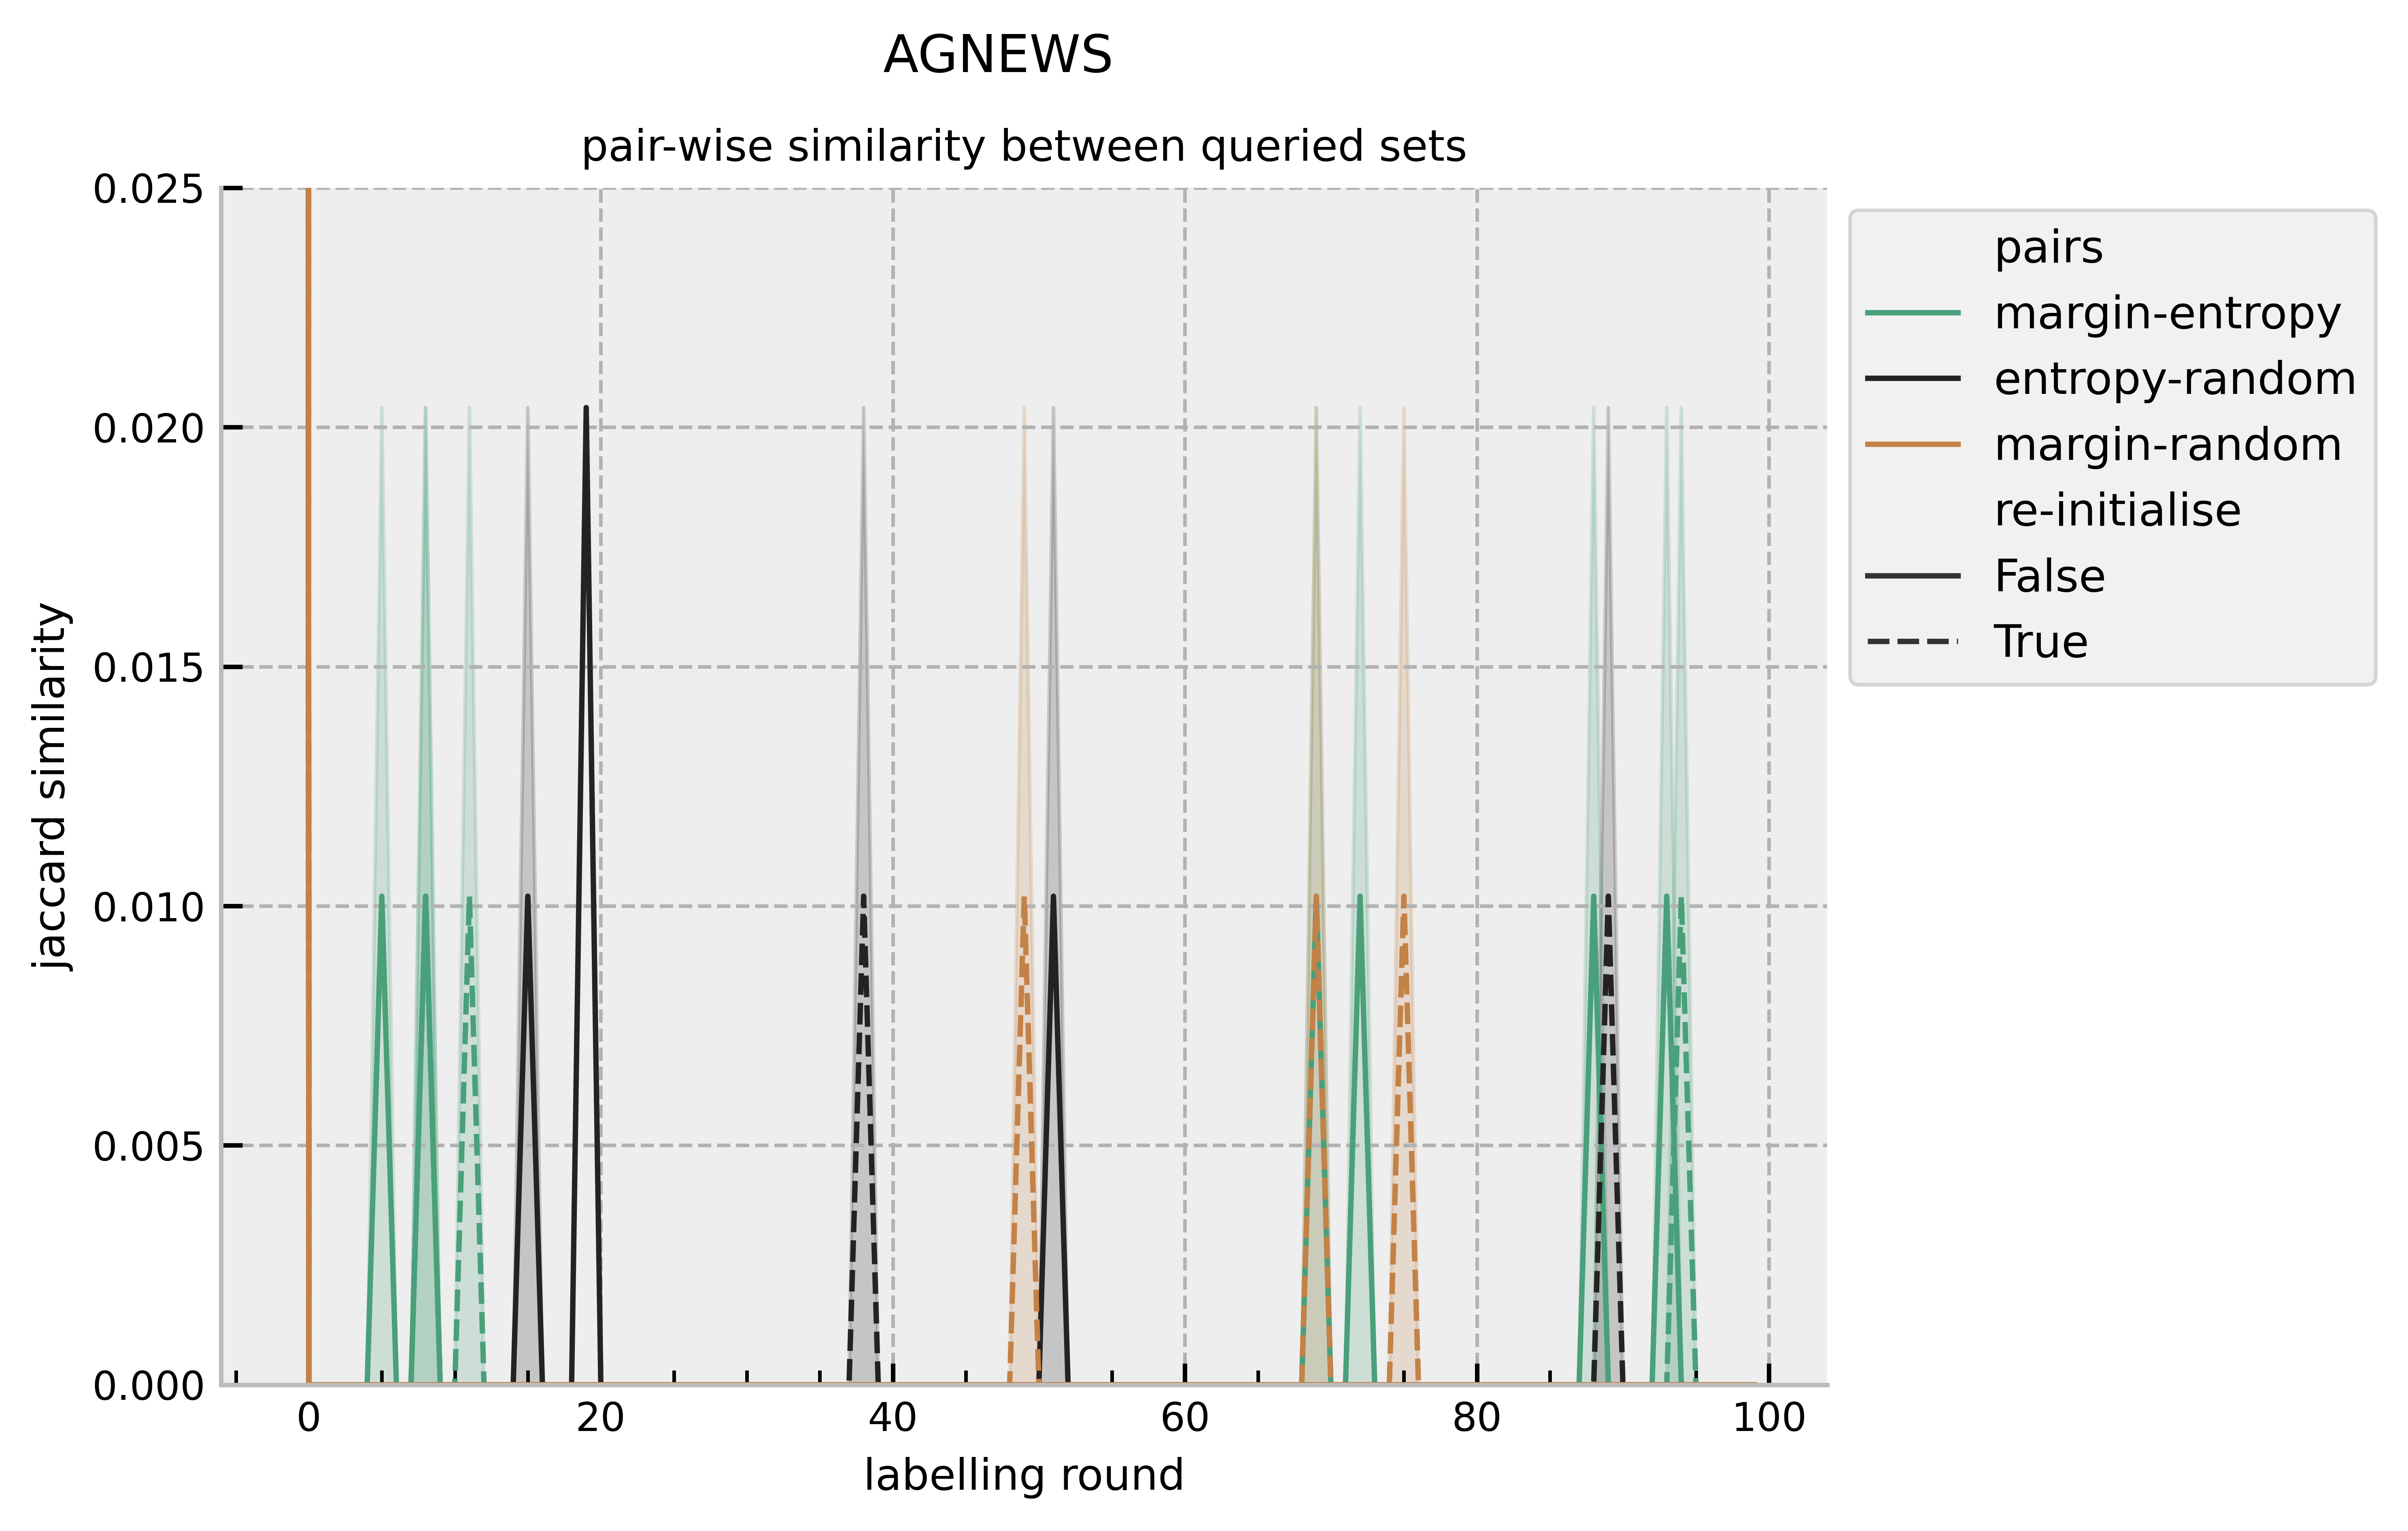

In [244]:
plt.style.use("bmh")
sns.set_context("paper")
palette = sns.diverging_palette(150, 40, l=60, center="dark", n=3)

fig, ax = plt.subplots()

sns.lineplot(
    data=dd,
    x="labelling_round",
    y="value",
    hue="pairs",
    style="re-initialise",
    ax=ax,
    palette=palette,
)
fig.dpi = 800
fig.suptitle("AGNEWS")
ax.set_title("pair-wise similarity between queried sets")
ax.set_ylabel("jaccard similarity")
ax.set_xlabel("labelling round")
ax.set_ylim(0.0, 0.025)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), fontsize=10)
# ax.legend(fontsize=10, bbox_to_anchor=(1, 1))
sns.despine()
plt.show()